# Planetary Transits Part 2: *Classifying Transits*

In [](content:references:transits_part1), we introduced observations of planetary transits as periodic dips in the light curve and how they may be identified. We also discussed the presence of stellar and instrumental variability that can appear as dips, but are not planetary in nature.

At the end of that Section, we described how the shape of the transits offers a way to distinguish true planetary transits from false positives. In other words, we want to distinguish the following:

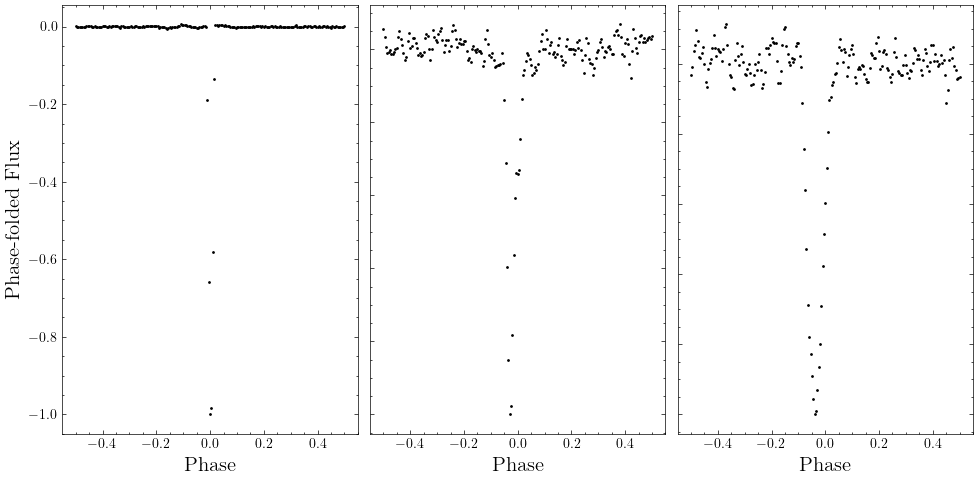

In [352]:
import os, torch
import numpy as np
import torch.nn as nn
import pandas as pd
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
import scienceplots

from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam
from pathlib import Path
from astropy.io import fits
from copy import copy
from torchinfo import summary

data_folder_path = Path.cwd().resolve().parent.parent / 'ml_astro' / 'chapter1' / 'data'

plt.style.use('science')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

fs = 18

data = np.load('/home/marc/notebooks/astronet/AstronetGlobalLocalView.npz')
flux_global=data['flux_global']
flux_local = data['flux_loc']
tic = data['tic']  

unique_tic, indices = np.unique(tic, return_index=True)
flux_global, flux_local, tic = flux_global[indices], flux_local[indices], tic[indices]

def plot_trio_panel(ticids):
    fig = plt.figure(figsize=(10, 5))
    ax1, ax2, ax3 = fig.add_subplot(131), fig.add_subplot(132), fig.add_subplot(133)
    for i, ax in zip(range(3), [ax1,ax2, ax3]):
        ax.scatter(np.linspace(-0.5, 0.5, len(flux_global[tic == ticids[i]].squeeze())),
            flux_global[tic == ticids[i]].squeeze(),s=1, c='k' )
        ax.set_xlabel('Phase', fontsize=fs-3)
        if i != 0:
            ax.set_yticklabels([])
        else:
            ax.set_ylabel('Phase-folded Flux', fontsize=fs-3)    
    plt.tight_layout(w_pad=0.2)
    plt.show()
plot_trio_panel(ticids = [323878236, 29831208, 453100658])

from false positive cases like the following:

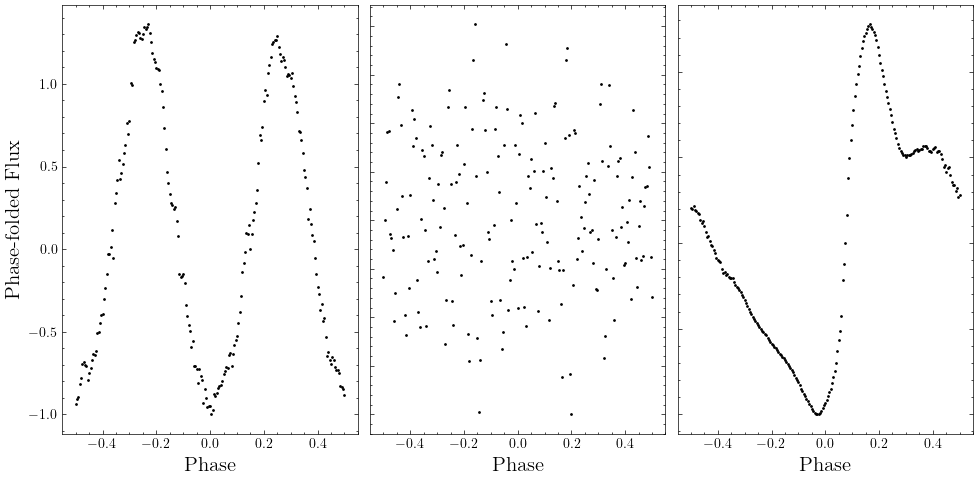

In [97]:
plot_trio_panel(ticids = [467961579, 260302492, 41233766])

The range of observed phenomena is vast, and the morphology of these transits can be quite complex. It is for these reasons that deep learning can be well-suited to classify between these types of objects.

## Classifying Phase-Folded Light Curves with a ConvNet

We will train a convolutional neural network to classify the shape of the phase-folded light curves, identifying those potentially from a planet versus those that are distinctly non-planetary in nature.

For a training set, we will use the dataset from {cite}`Tey_2023`, which curates a list of stars that have been vetted for transit based on observations from the TESS mission. The catalog lists the following classification labels:

- **"E"** - periodic eclipsing signal
- **"S"** - incorrect period
- **"B"** - contact eclipsing binaries
- **"J"** - astrophysical variability/instrumental artifacts
- **"N"** - not sure

The catalog reports a label from the consensus of a minimum of 3 vetters, who categorized the sample of $\sim25,000$ targets by eye. Labels are not given to training samples for which a consensus is not arrived.

In [106]:
tce = pd.read_csv('/home/marc/notebooks/astronet/tces_with_labels_v3.csv', comment='#').drop_duplicates(subset='TIC ID')
tce[['TIC ID', 'Epoch', 'Period', 'Duration', 'Depth','Consensus Label']]

,TIC ID,Epoch,Period,Duration,Depth,Consensus Label
0,387242167,1655.407925,4.081254,0.180881,330,NaN
1,141709436,1338.471105,24.959872,0.218898,640,J
2,407089973,1626.073791,0.365865,0.064751,24320,B
3,261007876,1342.968554,42.528679,0.655792,3830,J
4,31265416,1351.981451,35.055941,0.276942,1030,E
...,...,...,...,...,...,...
24921,91037668,2035.837020,0.552550,0.033167,744,J
24922,92625873,1342.985400,17.021960,0.083583,98820,J
24923,92655287,1343.713570,17.813630,0.120417,240940,J
24924,96142134,1518.266040,0.606250,0.072750,49940,NaN


```{important}
The data needs to be pre-formatted before utilized as samples in a dataset for any machine learning tasks. Similar to [](content:references:eclipse_part1), the phase-folded light curves need to be normalized and binned into a fixed length across all samples in the dataset.

Another crucial aspect of formatting the data is **de-trending**. Activity from the star can produce fast or slow light curve variations that distort the shape of the phase-folded transits and hinders a proper classification of a planetary transit.
```

## A First Attempt: Classification using a Global View

To begin, we will classify the phase-folded light curve across the full orbit, denoted as the **global view**. For simplicity, we will consider labels **"E"** and **"B"** as positive samples, and everything else as negative samples.


In [103]:
pos_ids = tce['TIC ID'][(tce['Consensus Label'] == 'E') | (tce['Consensus Label'] == 'B')].values
neg_ids = tce['TIC ID'][ ~( (tce['Consensus Label'] == 'E') | (tce['Consensus Label'] == 'B'))].values
print(f'Ratio of Positive to Negative Examples: {len(pos_ids)/len(neg_ids) :.2f}')

Ratio of Positive to Negative Examples: 0.16


Let's split these samples into training and validation samples using `sklearn`'s `train_test_split`.

In [259]:
from sklearn.model_selection import train_test_split

pos_ids_train, pos_ids_val = train_test_split(pos_ids, test_size=0.2, random_state=42)
neg_ids_train, neg_ids_val = train_test_split(neg_ids, test_size=0.2, random_state=42)

Looks like we have a rather unbalanced dataset, and this is something we should consider in constructing our training sets. Next, we define our training dataloader using `torch`: 

In [425]:
batch_size = 64

train_x = torch.Tensor(flux_global[np.in1d(tic, pos_ids_train)]) # positive samples
train_x = torch.cat( (train_x, torch.Tensor(flux_global[np.in1d(tic, neg_ids_train)])), axis=0)# negative samples
train_y = torch.ones(len(flux_global[np.in1d(tic, pos_ids_train)]))# positive labels
train_y = torch.cat( (train_y, torch.zeros(len(flux_global[np.in1d(tic, neg_ids_train)]))), axis=0)# negative labels

val_x = torch.Tensor(flux_global[np.in1d(tic, pos_ids_val)]) 
val_x = torch.cat( (val_x, torch.Tensor(flux_global[np.in1d(tic, neg_ids_val)])), axis=0)
val_y = torch.ones(len(flux_global[np.in1d(tic, pos_ids_val)]))
val_y = torch.cat( (val_y, torch.zeros(len(flux_global[np.in1d(tic, neg_ids_val)]))), axis=0)

train_dataset = TensorDataset(train_x.to(device), train_y.to(device))
trainloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(val_x.to(device), val_y.to(device))
valloader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

and here we define the architecture in the form of a simple 1D ConvNet with the following structure:

```{figure} images/astronet1.png
---
height: 200px
width: 700px
name: astronet1
---

In [426]:
class GlobalViewClassifier(nn.Module):

    def __init__(self):
        super(GlobalViewClassifier, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=5, padding=2)  # conv5-16
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=16, kernel_size=5, padding=2)  # conv5-16
        self.pool1 = nn.MaxPool1d(kernel_size=7, stride=2)         
        
        self.conv3 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=5, padding=2)  # conv5-32
        self.conv4 = nn.Conv1d(in_channels=32, out_channels=32, kernel_size=5, padding=2)  # conv5-32
        self.pool2 = nn.MaxPool1d(kernel_size=7, stride=2)  # maxpool7-2
        
        self.fc1 = nn.Linear(1472, 64)  
        self.fc2 = nn.Linear(64, 64) 
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, 64)  
        self.output = nn.Linear(64, 1) 
        

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = self.pool1(x)
        
        x = torch.relu(self.conv3(x))
        x = torch.relu(self.conv4(x))
        x = self.pool2(x)
        
        x = x.view(x.size(0), -1)

        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        
        return self.output(x)
    
model = GlobalViewClassifier(); optimizer = Adam(model.parameters(), lr=1e-3)
summary(model, input_size=(1, 1, train_x.size(1)))

Layer (type:depth-idx)                   Output Shape              Param #
GlobalViewClassifier                     [1, 1]                    --
├─Conv1d: 1-1                            [1, 16, 201]              96
├─Conv1d: 1-2                            [1, 16, 201]              1,296
├─MaxPool1d: 1-3                         [1, 16, 98]               --
├─Conv1d: 1-4                            [1, 32, 98]               2,592
├─Conv1d: 1-5                            [1, 32, 98]               5,152
├─MaxPool1d: 1-6                         [1, 32, 46]               --
├─Linear: 1-7                            [1, 64]                   94,272
├─Linear: 1-8                            [1, 64]                   4,160
├─Linear: 1-9                            [1, 64]                   4,160
├─Linear: 1-10                           [1, 64]                   4,160
├─Linear: 1-11                           [1, 1]                    65
Total params: 115,953
Trainable params: 115,953
Non-trainable p

```{important}
The `torch.nn.BCEWithLogitsLoss()` loss function already applies a Sigmoid layer, so the network's output should be **logits**, rather than **probabilities**.
```

```{important}
Tensor sizes are (batch, num_channels, length).
```



Let's run this through a training loop:



In [427]:
criterion = torch.nn.BCEWithLogitsLoss()
num_epochs = 50

model.train()
train_cumulative_loss, val_cumulative_loss = [], []

for epoch in range(num_epochs): 
    model.train()
    epoch_loss = 0; correct_train = 0; total_train = 0
    
    for batch_idx, (x,y) in enumerate(trainloader): 
        x = x.to(device).reshape(x.size()[0], 1, x.size()[1])
        optimizer.zero_grad() 
        logits = model(x) 

        binary_loss = criterion(logits.squeeze(), y)     
        binary_loss.backward()  
        epoch_loss += binary_loss.item()
        optimizer.step() 
        
        preds = (torch.sigmoid(logits) > 0.5).squeeze()  # Convert logits to binary predictions
        correct_train += (preds == y).sum().item()  
        total_train += y.size(0)  

    train_accuracy = correct_train / total_train  
    
    # Validation phase
    model.eval() 
    val_loss = 0; correct_val = 0; total_val = 0
    with torch.no_grad():  
        for batch_val_idx, (x_val, y_val) in enumerate(valloader): 
            x_val = x_val.to(device).reshape(x_val.size()[0], 1, x_val.size()[1])
            y_val = y_val.to(device).float()

            logits_val = model(x_val)
            binary_loss = criterion(logits_val.squeeze(), y_val)     
            val_loss += binary_loss.item()

            preds_val = (torch.sigmoid(logits_val) > 0.5).squeeze()
            correct_val += (preds_val == y_val).sum().item()
            total_val += y_val.size(0)

    val_accuracy = correct_val / total_val   
    train_cumulative_loss.append(epoch_loss/(batch_idx*batch_size))
    val_cumulative_loss.append(val_loss/(batch_val_idx*batch_size))
         
    if not epoch % 10:   
        print(f"\tEpoch {epoch + 1}",
              f"\t Train Loss: {epoch_loss/(batch_idx*batch_size):.5f}",
             f"\t Training Acc.: {100*train_accuracy:.2f}%",
             f"\t Val Loss: {val_loss/(batch_idx*batch_size):.5f}",
                          f"Val Acc.: {100*val_accuracy:.2f}%",)


	Epoch 1 	 Train Loss: 0.00350 	 Training Acc.: 90.48% 	 Val Loss: 0.00066 Val Acc.: 92.95%
	Epoch 11 	 Train Loss: 0.00218 	 Training Acc.: 94.85% 	 Val Loss: 0.00054 Val Acc.: 94.44%
	Epoch 21 	 Train Loss: 0.00177 	 Training Acc.: 95.62% 	 Val Loss: 0.00054 Val Acc.: 94.89%
	Epoch 31 	 Train Loss: 0.00125 	 Training Acc.: 96.78% 	 Val Loss: 0.00073 Val Acc.: 94.65%
	Epoch 41 	 Train Loss: 0.00124 	 Training Acc.: 97.05% 	 Val Loss: 0.00082 Val Acc.: 94.71%


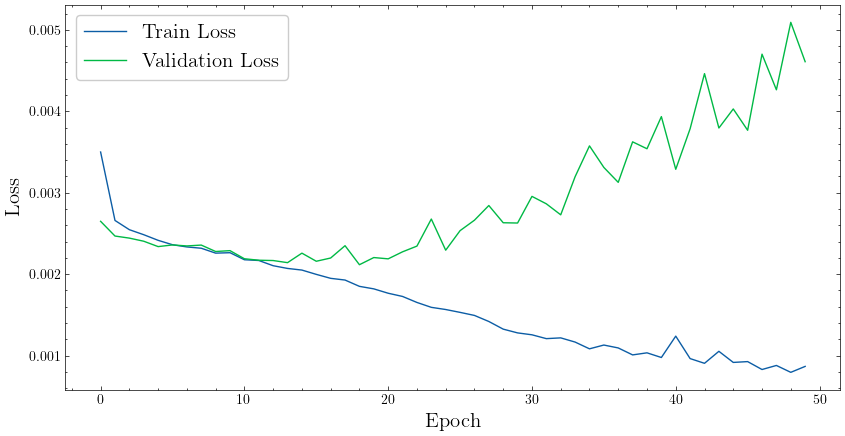

In [429]:
fig = plt.figure(figsize=(10, 5));

plt.plot(np.arange(num_epochs), train_cumulative_loss, label='Train Loss')
plt.plot(np.arange(num_epochs), val_cumulative_loss, label='Validation Loss')

plt.legend(frameon=True, prop={'size': fs-3},
          framealpha=1); plt.xlabel('Epoch', fontsize=fs-3); plt.ylabel('Loss', fontsize=fs-3)
plt.show()

This looks like a typical case of overfitting! We could have terminating the training at roughly 10 epochs, which would have already yielded a very reasonable perfomance. Let's examine the confusion matrix for the network:

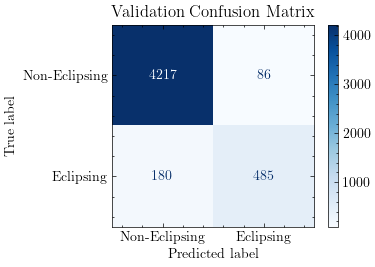

In [430]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

model.eval() 

all_preds = []; all_labels = []
false_positives = []; false_negatives = []
with torch.no_grad():
    for batch_idx, (x, y) in enumerate(valloader):
        x = x.to(device).reshape(x.size()[0], 1, x.size()[1]) 
        y = y.to(device)
        
        logits = model(x)
        predictions = torch.sigmoid(logits).squeeze()  
        preds = (predictions >= 0.5).long()
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())
        
       # Track false positives and false negatives
        for i in range(len(y)):
            if preds[i] == 1 and y[i] == 0:  # False Positive
                false_positives.append((batch_idx, i, x[i], y[i], preds[i])) 
            elif preds[i] == 0 and y[i] == 1:  # False Negative
                false_negatives.append((batch_idx, i, x[i], y[i], preds[i])) 

conf_matrix = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["Non-Eclipsing", "Eclipsing"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Validation Confusion Matrix")
plt.show()

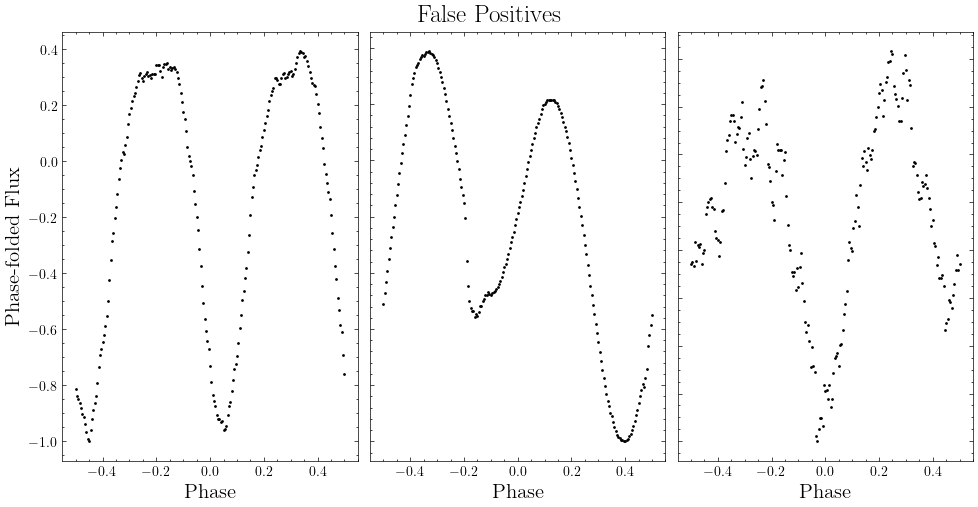

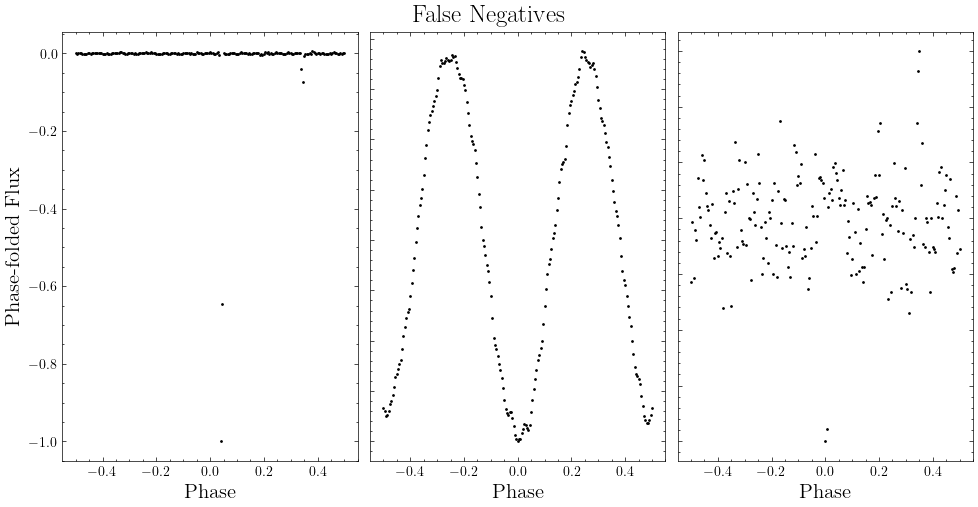

In [346]:
def plot_bad_pred(pred_data, title):
    fig = plt.figure(figsize=(10, 5))
    ax1, ax2, ax3 = fig.add_subplot(131), fig.add_subplot(132), fig.add_subplot(133)
    for idx, (i, ax) in enumerate(zip(np.random.randint(len(pred_data), size=3), [ax1,ax2, ax3])):
        ax.scatter(np.linspace(-0.5, 0.5, train_x.size()[1]),
            pred_data[i][2].data.cpu().numpy().squeeze(),s=1, c='k' )
        ax.set_xlabel('Phase', fontsize=fs-3)
        if idx != 0:
            ax.set_yticklabels([])
        else:
            ax.set_ylabel('Phase-folded Flux', fontsize=fs-3)    
    plt.tight_layout(w_pad=0.2)
    plt.suptitle(title, fontsize=fs, y=1.025)
    plt.show()
plot_bad_pred(false_positives, title='False Positives')
plot_bad_pred(false_negatives, title='False Negatives')

Based on the visualized examples of false negatives and false positives, the weakness of the current approach is identifiable:

- Based on the current (global) data representation, short-duration eclipses may only be represented by a few data points, which is insufficient
- In addition, there may be some confusion regarding an eclipsing signal from a binary star with some "Junk" signals from other sources of astrophysical nature (i.e., rotation, pulsations). The current representation doesn't offer much to help disentangle between these.


## The Local View

To remedy these issues, a **local** view of the phase-folded light curve is also added as an input, which better represents the shape of the primary eclipse. In this example, the local view uses the same number of bins (sequence length = 201) as the global view, but the bins range over $\pm2T$ from the central eclipse.

```{note}
The duration $T$ of the eclipse can generally be estimated from the Box Least-Squares algorithm, where a rough estimate would usually suffice to create the local view.
```

An example is shown below:

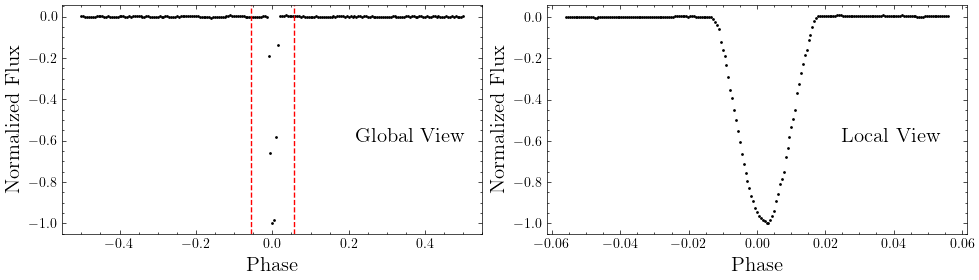

In [373]:
def plot_duo_panel(ticids):
    fig = plt.figure(figsize=(10, 3))
    ax1, ax2 = fig.add_subplot(121), fig.add_subplot(122),
    ax1.scatter(np.linspace(-0.5, 0.5, len(flux_global[tic == ticids].squeeze())),
        flux_global[tic == ticids].squeeze(),s=1, c='k' )
    ax1.set_xlabel('Phase', fontsize=fs-3); ax1.text(x=0.7, y=0.4, s='Global View', fontsize=fs-3, transform=ax1.transAxes)
    ax1.axvline(x=-2*(tce.Duration.values/tce.Period.values)[tce["TIC ID"] == ticids], c='r', ls='--')
    ax1.axvline(x=2*(tce.Duration.values/tce.Period.values)[tce["TIC ID"] == ticids], c='r', ls='--')
    ax1.set_ylabel('Normalized Flux', fontsize=fs-3)
    
    ax2.scatter(np.linspace(-2*(tce.Duration.values/tce.Period.values)[tce["TIC ID"] == ticids],
                            2*(tce.Duration.values/tce.Period.values)[tce["TIC ID"] == ticids], len(flux_local[tic == ticids].squeeze())),
        flux_local[tic == ticids].squeeze(),s=1, c='k' )
    ax2.set_xlabel('Phase', fontsize=fs-3) ;ax2.text(x=0.7, y=0.4, s='Local View', fontsize=fs-3, transform=ax2.transAxes)
    ax2.set_ylabel('Normalized Flux', fontsize=fs-3)

    plt.tight_layout(w_pad=0.2)
    plt.show()
plot_duo_panel(ticids = 323878236)

In the above, the regions within the dashed lines indicate the region of the phase-folded light curve that is now focused upon and binned to greater detail with the local view. 

Let's apply this additional information into the network, carefully making the distinction between **local** and **global** view inputs in our new trainloader and dataloader:

In [431]:
train_x_local= torch.Tensor(flux_local[np.in1d(tic, pos_ids_train)]) 
train_x_local= torch.cat( (train_x_local, torch.Tensor(flux_local[np.in1d(tic, neg_ids_train)])), axis=0)

train_x_global = torch.Tensor(flux_global[np.in1d(tic, pos_ids_train)]) 
train_x_global = torch.cat( (train_x_global, torch.Tensor(flux_global[np.in1d(tic, neg_ids_train)])), axis=0)

train_x = torch.cat([train_x_local.unsqueeze(1), train_x_global.unsqueeze(1)], 1)

val_x_local= torch.Tensor(flux_local[np.in1d(tic, pos_ids_val)]) 
val_x_local= torch.cat( (val_x_local, torch.Tensor(flux_local[np.in1d(tic, neg_ids_val)])), axis=0)

val_x_global = torch.Tensor(flux_global[np.in1d(tic, pos_ids_val)]) 
val_x_global = torch.cat( (val_x_global, torch.Tensor(flux_global[np.in1d(tic, neg_ids_val)])), axis=0)

val_x = torch.cat([val_x_local.unsqueeze(1), val_x_global.unsqueeze(1)], 1)


train_dataset = TensorDataset(train_x.to(device), train_y.to(device))
trainloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(val_x.to(device), val_y.to(device))
valloader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

Correspondingly, we should modify our 1D ConvNet to incorporate this additional information. There are now two convolutional branches for each view, where for simplicity, the architecture of the "local" convolutional branch is adopted to be identical to that of the global view.

```{figure} images/globallocal_astronet.png
---
height: 400px
width: 700px
name: globallocal_astronet
---


In [432]:
class ConvBlock(nn.Module): # Refactoring
    def __init__(self, in_channels, out_channels, kernel_size=5, pool_kernel_size=7, pool_stride=2):
        super(ConvBlock, self).__init__()
        
        self.conv1 = nn.Conv1d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding=kernel_size//2)
        self.conv2 = nn.Conv1d(in_channels=out_channels, out_channels=out_channels, kernel_size=kernel_size, padding=kernel_size//2)
        self.pool = nn.MaxPool1d(kernel_size=pool_kernel_size, stride=pool_stride)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)  
        x = self.conv2(x)
        x = torch.relu(x) 
        x = self.pool(x) 
        return x


class GlobalLocalViewClassifier(nn.Module):

    def __init__(self):
        super(GlobalLocalViewClassifier, self).__init__()
        
        self.conv_block_local1 = ConvBlock(in_channels=1, out_channels=16)
        self.conv_block_local2 = ConvBlock(in_channels=16, out_channels=32)
        
        self.conv_block_global1 = ConvBlock(in_channels=1, out_channels=16)
        self.conv_block_global2 = ConvBlock(in_channels=16, out_channels=32)
        
        self.fc1 = nn.Linear(1472*2, 64)  # Fully connected 1
        self.fc2 = nn.Linear(64, 64)  # Fully connected 2
        self.fc3 = nn.Linear(64, 64)  # Fully connected 3
        self.fc4 = nn.Linear(64, 64)  # Fully connected 4
        self.output = nn.Linear(64, 1)  # Logistic sigmoid output
        

    def forward(self, x):
        x_local = self.conv_block_local2(self.conv_block_local1(x[:, 0, :].unsqueeze(1)))
        x_global = self.conv_block_global2(self.conv_block_global1(x[:, 1, :].unsqueeze(1)))
        
        x_local = x_local.view(x_local.size(0), -1)
        x_global = x_global.view(x_local.size(0), -1)

        x = torch.cat([x_local, x_global], dim=1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        
        return self.output(x)
    
model = GlobalLocalViewClassifier(); optimizer = Adam(model.parameters(), lr=1e-4)
summary(model, input_size=(1, 2, train_x.size(-1)))

Layer (type:depth-idx)                   Output Shape              Param #
GlobalLocalViewClassifier                [1, 1]                    --
├─ConvBlock: 1-1                         [1, 16, 98]               --
│    └─Conv1d: 2-1                       [1, 16, 201]              96
│    └─Conv1d: 2-2                       [1, 16, 201]              1,296
│    └─MaxPool1d: 2-3                    [1, 16, 98]               --
├─ConvBlock: 1-2                         [1, 32, 46]               --
│    └─Conv1d: 2-4                       [1, 32, 98]               2,592
│    └─Conv1d: 2-5                       [1, 32, 98]               5,152
│    └─MaxPool1d: 2-6                    [1, 32, 46]               --
├─ConvBlock: 1-3                         [1, 16, 98]               --
│    └─Conv1d: 2-7                       [1, 16, 201]              96
│    └─Conv1d: 2-8                       [1, 16, 201]              1,296
│    └─MaxPool1d: 2-9                    [1, 16, 98]               --
├─C

In [433]:
criterion = torch.nn.BCEWithLogitsLoss()
num_epochs = 50

model.train()
train_cumulative_loss, val_cumulative_loss = [], []

for epoch in range(num_epochs): 
    model.train()
    epoch_loss = 0; correct_train = 0; total_train = 0
    
    for batch_idx, (x,y) in enumerate(trainloader): 
        x = x.to(device)#.reshape(x.size()[0], 1, x.size()[1])
        optimizer.zero_grad() 
        logits = model(x) 

        binary_loss = criterion(logits.squeeze(), y)     
        binary_loss.backward()  
        epoch_loss += binary_loss.item()
        optimizer.step() 
        
        preds = (torch.sigmoid(logits) > 0.5).squeeze()  # Convert logits to binary predictions
        correct_train += (preds == y).sum().item()  
        total_train += y.size(0)  

    train_accuracy = correct_train / total_train  
    
    # Validation phase
    model.eval() 
    val_loss = 0; correct_val = 0; total_val = 0
    with torch.no_grad():  
        for batch_val_idx, (x_val, y_val) in enumerate(valloader): 
            x_val = x_val.to(device)#.reshape(x_val.size()[0], 1, x_val.size()[1])
            y_val = y_val.to(device).float()

            logits_val = model(x_val)
            binary_loss = criterion(logits_val.squeeze(), y_val)     
            val_loss += binary_loss.item()

            preds_val = (torch.sigmoid(logits_val) > 0.5).squeeze()
            correct_val += (preds_val == y_val).sum().item()
            total_val += y_val.size(0)

    val_accuracy = correct_val / total_val   
    train_cumulative_loss.append(epoch_loss/(batch_idx*batch_size))
    val_cumulative_loss.append(val_loss/(batch_val_idx*batch_size))
         
    if not epoch % 10:   
        print(f"\tEpoch {epoch + 1}",
              f"\t Train Loss: {epoch_loss/(batch_idx*batch_size):.5f}",
             f"\t Training Acc.: {100*train_accuracy:.2f}%",
             f"\t Val Loss: {val_loss/(batch_idx*batch_size):.5f}",
                          f"Val Acc.: {100*val_accuracy:.2f}%",)


	Epoch 1 	 Train Loss: 0.00560 	 Training Acc.: 86.53% 	 Val Loss: 0.00081 Val Acc.: 86.61%
	Epoch 11 	 Train Loss: 0.00229 	 Training Acc.: 94.65% 	 Val Loss: 0.00056 Val Acc.: 94.71%
	Epoch 21 	 Train Loss: 0.00215 	 Training Acc.: 94.98% 	 Val Loss: 0.00055 Val Acc.: 94.93%
	Epoch 31 	 Train Loss: 0.00200 	 Training Acc.: 95.23% 	 Val Loss: 0.00056 Val Acc.: 94.50%
	Epoch 41 	 Train Loss: 0.00188 	 Training Acc.: 95.56% 	 Val Loss: 0.00051 Val Acc.: 95.53%


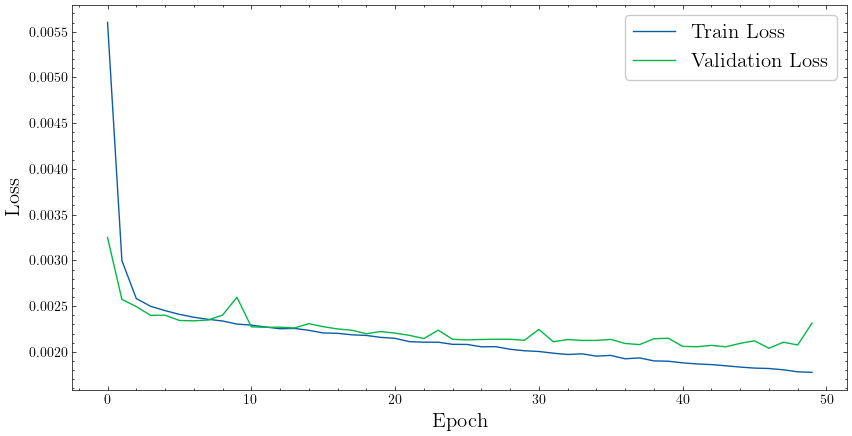

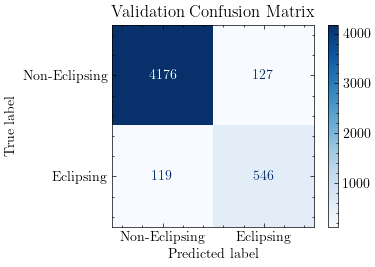

In [434]:
fig = plt.figure(figsize=(10, 5));

plt.plot(np.arange(num_epochs), train_cumulative_loss, label='Train Loss')
plt.plot(np.arange(num_epochs), val_cumulative_loss, label='Validation Loss')

plt.legend(frameon=True, prop={'size': fs-3},
          framealpha=1); plt.xlabel('Epoch', fontsize=fs-3); plt.ylabel('Loss', fontsize=fs-3)
plt.show()

model.eval() 

all_preds = []; all_labels = []
false_positives = []; false_negatives = []
with torch.no_grad():
    for batch_idx, (x, y) in enumerate(valloader):
        x = x.to(device)#.reshape(x.size()[0], 1, x.size()[1]) 
        y = y.to(device)
        
        logits = model(x)
        predictions = torch.sigmoid(logits).squeeze()  
        preds = (predictions >= 0.5).long()
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())
        
       # Track false positives and false negatives
        for i in range(len(y)):
            if preds[i] == 1 and y[i] == 0:  # False Positive
                false_positives.append((batch_idx, i, x[i], y[i], preds[i])) 
            elif preds[i] == 0 and y[i] == 1:  # False Negative
                false_negatives.append((batch_idx, i, x[i], y[i], preds[i])) 

conf_matrix = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["Non-Eclipsing", "Eclipsing"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Validation Confusion Matrix")
plt.show()

While the gains are modest, there is certainly improvement in reducing the number of true eclipsing targets that are labelled as non-eclipsing.

The take-away from this exercise is that the use of different or complementary representations of the data can often provide additional vital information that yields a better model performance.


`````{admonition} Exercise

The full Astronet has this structure:

```{figure} images/full_astronet.png
---
height: 400px
width: 700px
name: full_astronet
---



Experiment with changing the following:

- Convert this into a multi-class example, focusing only on eclipsing $(**E**)$ as the positive example.
- Handling the sample imbalances within the dataset
- Including other 'views' or auxiliary information into the classifier

`````

## Further Reading

There is a rich body of literature in the use of deep learning to identify the presence of transits from space-based planet-hunting missions. The following are some published papers on the topic:

[[1]](https://ui.adsabs.harvard.edu/abs/2023AJ....165...95T) Identifying Exoplanets with Deep Learning. V. Improved Light-curve Classification for TESS Full-frame Image Observations {cite}`Tey_2023`

[[2]](https://ui.adsabs.harvard.edu/abs/2022AJ....163...23C) Identify Light-curve Signals with Deep Learning Based Object Detection Algorithm. I. Transit Detection. {cite}`Cui_2022`

[[3]](https://ui.adsabs.harvard.edu/abs/2022ApJ...926..120V) ExoMiner: A Highly Accurate and Explainable Deep Learning Classifier That Validates 301 New Exoplanets. {cite}`Valizadegan_2022`

[[4]](https://ui.adsabs.harvard.edu/abs/2021AJ....161..273O) Identifying Planetary Transit Candidates in TESS Full-frame Image Light Curves via Convolutional Neural Networks. {cite}`Olmschenk_2021`

[[5]](https://ui.adsabs.harvard.edu/abs/2018AJ....155...94S) Identifying Exoplanets with Deep Learning: A Five-planet Resonant Chain around Kepler-80 and an Eighth Planet around Kepler-90. {cite}`Shallue_2018`